# 最終課題：犬と猫の分類

このノートブックでは、犬と猫の画像を分類する深層学習モデルを構築します。
手順は以下になります。

1. **準備**：  
必要なライブラリのインポートとデータセットへのパス設定
2. **データ読み込み**：  
`image_dataset_from_directory` を用いて、フォルダから画像を読み込みます。
3. **データの前処理（水増し）**：  
読み込んだ訓練データに対し、回転や反転処理を行い、データ量を増やします。
4. **モデルの構築**：  
事前学習済みの `MobileNetV2` モデルをベースに、転移学習を行います。
5. **モデルのコンパイルと学習**：  
作成したモデルをコンパイルし、準備したデータセットで学習させます。
6. **モデルの評価**：  
学習済みモデルをテストデータで評価し、その性能（正答率）を確認します。

## 1. 準備

### 1.1. ライブラリのインポート
モデルの構築と学習に必要なライブラリをインポートします。

In [27]:
import tensorflow as tf
import matplotlib.pyplot as plt
import os

### 1.2. データセットのパス設定
学習データとテストデータが格納されているディレクトリへのパスを設定します。  
このノートブックと同じ階層に `dog_cat_photos` フォルダが配置されていることを前提とします。

In [37]:
base_dir = 'dog_cat_photos'

train_dir = os.path.join(base_dir, 'train')
test_dir = os.path.join(base_dir, 'test')

# 各ディレクトリのパス
train_dog_dir = os.path.join(train_dir, 'dog')
train_cat_dir = os.path.join(train_dir, 'cat')
test_dog_dir = os.path.join(test_dir, 'dog')
test_cat_dir = os.path.join(test_dir, 'cat')

print('---データ数---')
print('訓練用 犬画像:', len(os.listdir(train_dog_dir)))
print('訓練用 猫画像:', len(os.listdir(train_cat_dir)))
print('テスト用 犬画像:', len(os.listdir(test_dog_dir)))
print('テスト用 猫画像:', len(os.listdir(test_cat_dir)))

---データ数---
訓練用 犬画像: 150
訓練用 猫画像: 150
テスト用 犬画像: 50
テスト用 猫画像: 50


## 2. データ読み込み

`tf.keras.preprocessing.image_dataset_from_directory()` を使用して、訓練データとテストデータを読み込みます。  
このとき、`MobileNetV2` が要求する画像サイズ `224x224` に自動的にリサイズされます。

In [38]:
IMG_SIZE = (224, 224)
BATCH_SIZE = 32

# 訓練データとテストデータの画像を読み込む
train_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    train_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = tf.keras.preprocessing.image_dataset_from_directory(
    test_dir,
    image_size=IMG_SIZE,
    label_mode="binary",
    batch_size=BATCH_SIZE,
    shuffle=False
)

Found 300 files belonging to 2 classes.
Found 100 files belonging to 2 classes.


### 読み込んだデータの確認
クラス名（フォルダ名）と、読み込まれた画像の一部を可視化して確認します。

['cat', 'dog']


2025-08-07 14:09:47.087585: I tensorflow/core/framework/local_rendezvous.cc:405] Local rendezvous is aborting with status: OUT_OF_RANGE: End of sequence


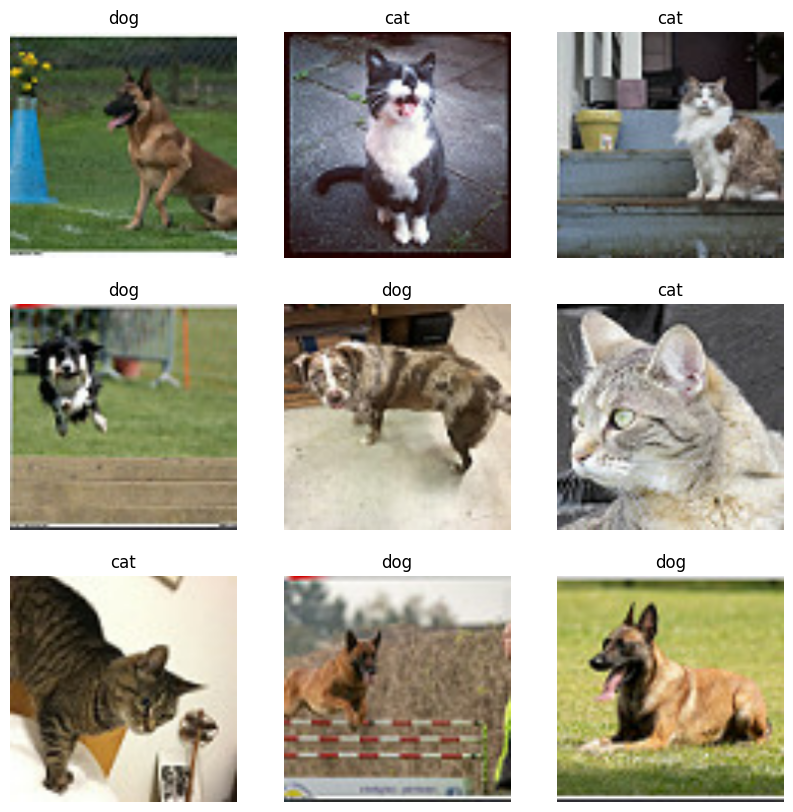

In [39]:
# クラス名を確認 (0: cat, 1: dog)
class_names = train_dataset.class_names
print(class_names)

# 訓練データの一部を表示して確認
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        # labelsはバイナリ形式なので、整数にキャストしてクラス名を取得
        plt.title(class_names[int(labels[i])])
        plt.axis("off")
plt.show()

## 3. データの前処理（水増し）

学習データの枚数を増やすため、データ拡張（水増し）を行います。  
左右反転、上下反転、回転処理を適用し、元のデータセットに結合します。

In [31]:
# 画像の水増しをする関数の定義
def flip_left_right(image, label): # 左右反転
    image = tf.image.flip_left_right(image)
    return image, label

def flip_up_down(image, label): # 上下反転
    image = tf.image.flip_up_down(image)
    return image, label

def rot90(image, label): # 反時計回りに90度回転
    image = tf.image.rot90(image)
    return image, label

# map()メソッドを使って各水増し処理を適用
train_dataset_lr = train_dataset.map(flip_left_right)
train_dataset_ud = train_dataset.map(flip_up_down)
train_dataset_rot90 = train_dataset.map(rot90)

# concatenate()メソッドで水増ししたデータを訓練データに追加
train_dataset = train_dataset.concatenate(train_dataset_lr)
train_dataset = train_dataset.concatenate(train_dataset_ud)
train_dataset = train_dataset.concatenate(train_dataset_rot90)

# データをシャッフルする
train_dataset = train_dataset.shuffle(BATCH_SIZE * 4) # データが増えたのでバッファサイズを調整

## 4. モデルの構築

`MobileNetV2` をベースモデルとして使用し、転移学習を行います。  
入力層、前処理層、ベースモデル、出力層を順に定義し、`Sequential`モデルとして結合します。

In [32]:
# 1. 入力層
input_layer = tf.keras.Input(shape=IMG_SIZE + (3,))

# 2. MobileNetV2用の前処理層
preprocess_layer = tf.keras.applications.mobilenet_v2.preprocess_input(input_layer)

# 3. MobileNetV2モデルの作成
base_model = tf.keras.applications.mobilenet_v2.MobileNetV2(
    input_shape=IMG_SIZE + (3,),
    input_tensor=preprocess_layer,
    include_top=False, # 全結合層は含めない
    weights='imagenet',   # ImageNetで学習済みの重みを使用
    pooling='avg' # GlobalAveragePoolingを適用
)

# ベースモデルの重みを凍結
base_model.trainable = False

# 4. 出力層
output_layer = tf.keras.layers.Dense(1, activation='sigmoid')

# 5. モデルの結合
model = tf.keras.Sequential([
    base_model,
    output_layer
])

# モデルのサマリーを表示
model.summary()

Model: "sequential_2"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ mobilenetv2_1.00_224            │ (None, 1280)           │     2,257,984 │
│ (Functional)                    │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_2 (Dense)                 │ (None, 1)              │         1,281 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,259,265 (8.62 MB)

 Trainable params: 1,281 (5.00 KB)

 Non-trainable params: 2,257,984 (8.61 MB)

## 5. モデルのコンパイルと学習

作成したモデルをコンパイルし、学習を開始します。
- **オプティマイザ**：`adam`
- **損失関数**：`binary_crossentropy`
- **評価指標**：`accuracy`

In [33]:
# モデルのコンパイル
model.compile(
    optimizer="adam",
    loss='binary_crossentropy',
    metrics=["accuracy"]
)

# 学習の実行
EPOCHS = 10
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=test_dataset
)

Epoch 1/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 9s 177ms/step - accuracy: 0.8542 - loss: 0.3750 - val_accuracy: 0.9800 - val_loss: 0.1412
Epoch 2/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9258 - loss: 0.2201 - val_accuracy: 0.9600 - val_loss: 0.0885
Epoch 3/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9342 - loss: 0.1714 - val_accuracy: 0.9800 - val_loss: 0.0804
Epoch 4/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 159ms/step - accuracy: 0.9542 - loss: 0.1410 - val_accuracy: 0.9800 - val_loss: 0.0688
Epoch 5/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 156ms/step - accuracy: 0.9583 - loss: 0.1256 - val_accuracy: 0.9800 - val_loss: 0.0663
Epoch 6/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 161ms/step - accuracy: 0.9667 - loss: 0.1088 - val_accuracy: 0.9800 - val_loss: 0.0764
Epoch 7/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 7s 171ms/step - accuracy: 0.9692 - loss: 0.1057 - val_accuracy: 0.9800 - val_loss: 0.0613
Epoch 8/10
40/40 ━━━━━━━━━━━━━━━━━━━━ 6s 157ms/step - accuracy: 0.9675 - loss: 0.0972 - val_accuracy: 0.

### 学習結果の可視化
学習の過程で得られた正答率と損失をグラフで確認します。

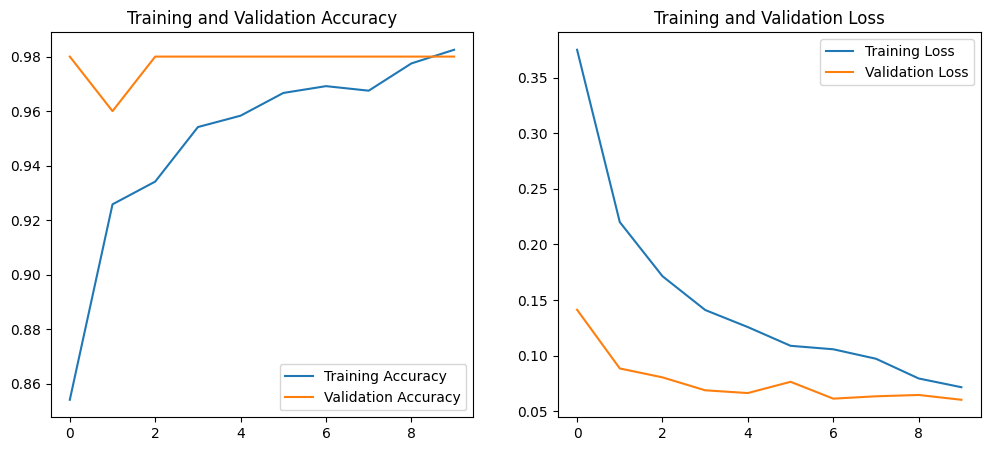

In [34]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs_range = range(EPOCHS)

plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(epochs_range, acc, label='Training Accuracy')
plt.plot(epochs_range, val_acc, label='Validation Accuracy')
plt.legend(loc='lower right')
plt.title('Training and Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(epochs_range, loss, label='Training Loss')
plt.plot(epochs_range, val_loss, label='Validation Loss')
plt.legend(loc='upper right')
plt.title('Training and Validation Loss')
plt.show()

## 6. モデルの評価

最後に、学習済みのモデルをテストデータセット全体で評価し、最終的な損失と正答率を算出します。  
`evaluate()` メソッドを使用します。

In [35]:
print("\n--- モデルの評価 ---")
loss, accuracy = model.evaluate(test_dataset)

print(f'Test Loss: {loss:.4f}')
print(f'Test Accuracy: {accuracy:.4f}')


--- モデルの評価 ---
4/4 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.9800 - loss: 0.0603
Test Loss: 0.0603
Test Accuracy: 0.9800
